## Helper Functions:

In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def sequences_generator(m, data_meas, logpost, t, stepsize, n_iter):
    problems = []
    for i in range(m):
        ui = np.random.randint(low=600, high=800)
        si = np.random.randint(low=100, high=200)
        shapei = np.random.choice(a=np.arange(0, -0.4, -0.01))
        theta =[ui, si, shapei]
        state = State(theta, logpost(theta, data_meas))
        problems.append(ProblemMCMC(state, logpost, stepsize, data_meas, t))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        u, s, shape, l, r = mcmc(problems[i], n_iter)
        mcmc_chains.append([u, s, shape])
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [12]:
def plot_sequences(mcmc_chains):
    for i in range(len(mcmc_chains)):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
        ax[0].plot(mcmc_chains[i][0], color="steelblue");
        ax[0].set_xlabel("Iteration");
        ax[0].set_ylabel("$\mu$ Trace");
        ax[0].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[0].grid(alpha=0.25);
        ax[1].plot(mcmc_chains[i][1], color="steelblue");
        ax[1].set_xlabel("Iteration");
        ax[1].set_ylabel("$\sigma$ Trace");
        ax[1].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[1].grid(alpha=0.25);
        ax[2].plot(mcmc_chains[i][2], color="steelblue");
        ax[2].set_xlabel("Iteration");
        ax[2].set_ylabel("shape parameter Trace");
        ax[2].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[2].grid(alpha=0.25);

## Data Preprocessing:

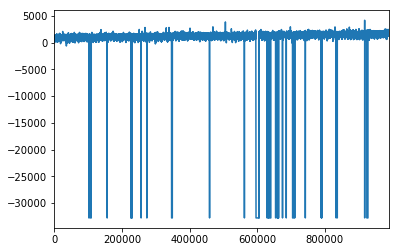

The fill in value is -32767.0


In [4]:
dfSL = pd.read_csv('Galveston.csv', header=None)
dfSL.rename(columns={0:'year',1:'month', 2:'day', 3:'hour', 4: 'sealevel'}, inplace=True)
fill_in = dfSL.loc[dfSL['sealevel']<-5000].median()[4]
dfSL['sealevel'].plot()
plt.show()
print ('The fill in value is {0}'.format(fill_in))

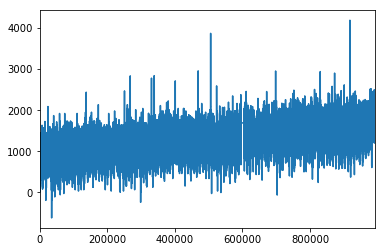

In [5]:
dfSL['sealevel'].replace(fill_in, np.nan, inplace=True)
dfSL.dropna(inplace= True)
dfSL['sealevel'].plot()
plt.show()

In [6]:
n_hours = 365*24
sl_year = {}
for index, row in dfSL.iterrows():
    year = row['year']
    sl = row['sealevel']
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)
        
gev= {}
for year, sealevel in sl_year.items():
    if len(sealevel)/n_hours >= 0.9:
        gev[year] = max(np.array(sealevel)-np.mean(sealevel))

There are 103 years we can use


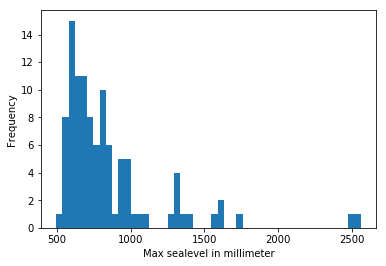

In [21]:
data_meas = list(gev.values())
print ('There are {0} years we can use'.format(len(data_meas)))
plt.hist(x=data_meas, bins=np.linspace(min(data_meas), max(data_meas)))
plt.xlabel('Max sealevel in millimeter')
plt.ylabel('Frequency')
plt.show()

## Likelihood Function:

In [47]:
def likelihood(parameters, data_meas=data_meas):
    u, s, shape = parameters                                                 
    prod = 1
    for i in range(len(data_meas)):
        pdf = stats.genextreme.pdf(x=data_meas[i], loc=u, scale=s, c=shape)
        if (pdf==0):
            return -np.inf
        prod += np.log(pdf)
    return prod

## Prior Distribution:

In [23]:
def prior(parameters):
    u, s, shape = parameters
    u_pdf = stats.norm.pdf(x=u, loc=0, scale=1000) # postive
    shape_pdf = stats.norm.pdf(x=shape, loc=0, scale=1000)
    if s >= 1000 or s <= 0 or u_pdf==0 or shape_pdf==0:
        return -np.inf
    else:
        return np.log(u_pdf)+np.log(1/1000)+np.log(shape_pdf)

## Posterior Distribution:

In [24]:
def logpost(parameters, data_meas):
    pi = prior(parameters)
    if pi == -np.inf:
        return -np.inf
    L = likelihood(parameters, data_meas)
    return L + pi

## Metropolis-Hastings Algorithm


In [25]:
eps = 0.0001
d = 3                                                                                                                                                                                                                                                                                                  
I_d = np.identity(d)
S_d = (2.4)**2/d
def update_cov(X):
    cov = np.cov(X)
    return S_d*cov + I_d*eps*S_d

In [26]:
class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class ProblemMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_meas, t):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t = t
        
    def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [27]:
def mcmc(problem, n_iter):

    u = [problem.current.state[0]] 
    s = [problem.current.state[1]]
    shape = [problem.current.state[2]]
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    
    with Pool(8) as p:
        for t in range(n_iter):
            S += 1
            nextMove, nextValue = problem.random_move(t, [u, s, shape])
            delta_obj = np.exp(nextValue - lpost[-1])
            if delta_obj > 1:
                # the proposed move is an improvement, so accept w.p. 1
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                shape.append(nextMove[2])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                # the proposed move is worse; accept with probability exp[delta_obj/T]
                p_accept = delta_obj
                accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
                if accept:
                    n_accept += 1
                    u.append(nextMove[0])
                    s.append(nextMove[1])
                    shape.append(nextMove[2])
                    lpost.append(nextValue)
                    problem.current.state = nextMove
                    problem.current.value = nextValue
                else:
                    u.append(u[-1])
                    s.append(s[-1])
                    shape.append(shape[-1])
                    lpost.append(lpost[-1])

    return (u, s, shape, lpost, n_accept/S)

In [28]:
mcmc_chains, ar, ls = sequences_generator(m=3, n_iter=10000, t=1000, data_meas=data_meas, logpost=logpost, stepsize=[10, 2, 0.01])

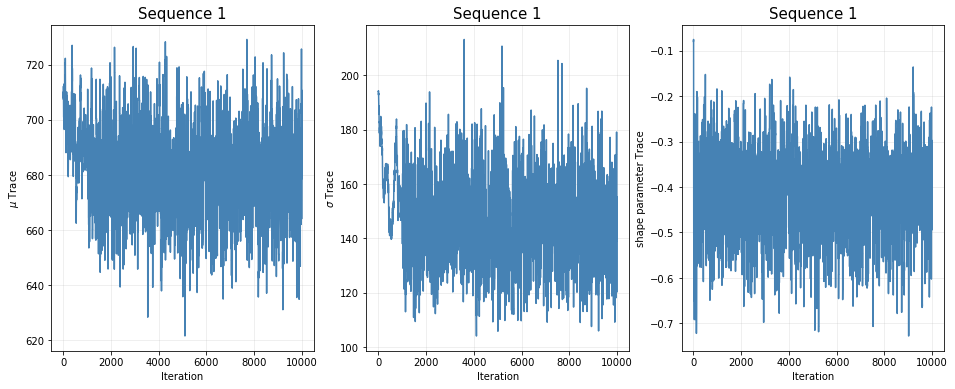

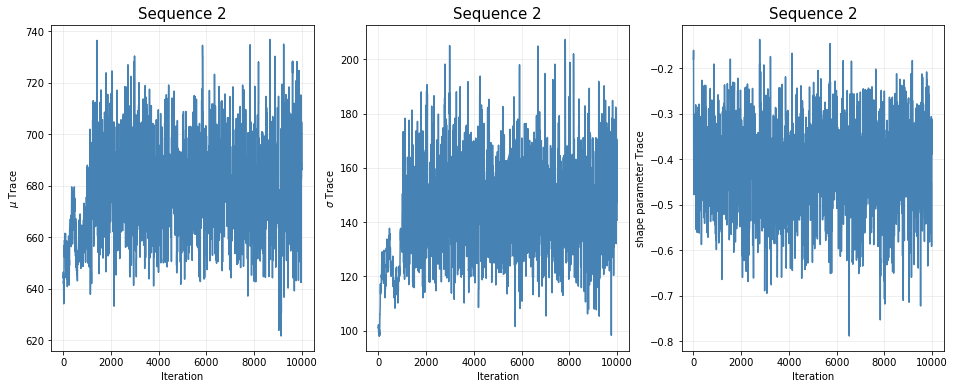

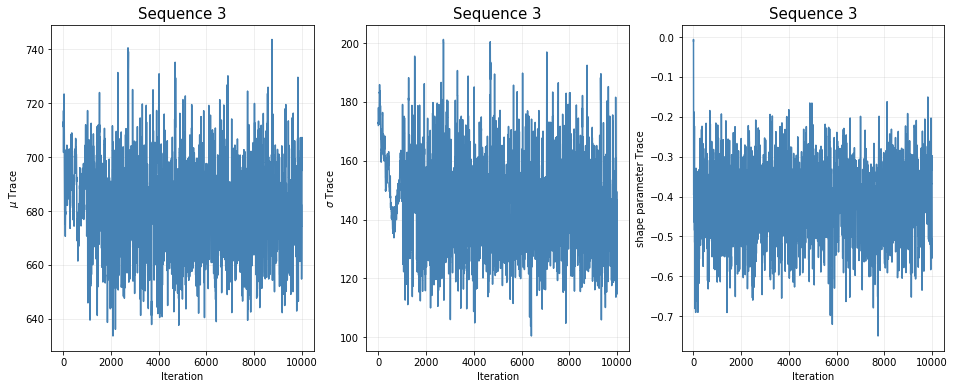

In [29]:
plot_sequences(mcmc_chains)

## GR diagnostic:

In [30]:
def GR_diag(parameter, interval=100, start=100, plot=True):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    x_range = []
    for n in range(start, end, interval):
        x_range.append(n)
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    if plot:
        plt.figure(figsize=(14, 6))
        plt.scatter(x=x_range, y=GR_result, label='GR diagnostic')
        plt.vlines(burnin*interval, ymin=1, ymax=max(GR_result), label='burn in={0}'.format(burnin*interval))
        plt.xlabel('iteration', fontsize=14)
        plt.ylabel('potential scale reduction fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.legend(loc='best')
        plt.show()
    return GR_result, burnin*interval

def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

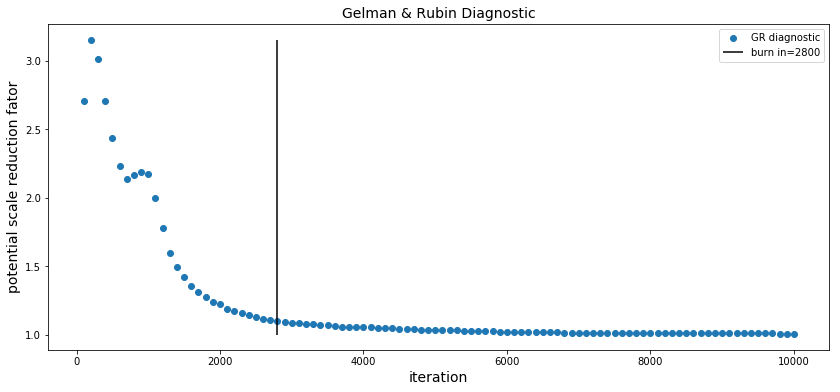

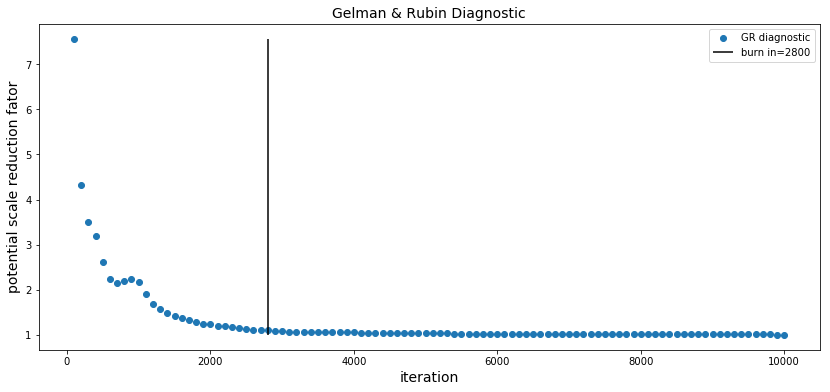

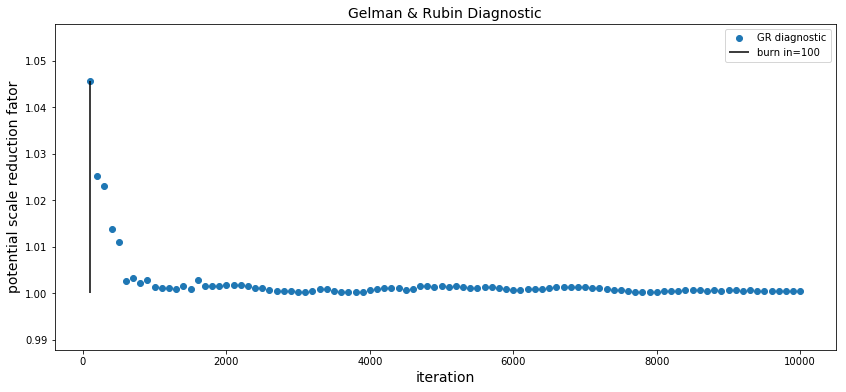

The burn in period should be 2800


In [31]:
u_raw, s_raw, shape_raw =[], [], []

for mcmc_chain in mcmc_chains:
    u_raw.append(mcmc_chain[0])
    s_raw.append(mcmc_chain[1])
    shape_raw.append(mcmc_chain[2])
    
    
GR_u, burnin1 = GR_diag(u_raw)
GR_s, burnin2 = GR_diag(s_raw)
GR_shape, burnin3 = GR_diag(shape_raw)
burnin = max([burnin1, burnin2, burnin3, 1000])
print ('The burn in period should be', burnin)

## Max log-posterior score parameter sets:

In [85]:
max_indices = []
maxs = []
for i in range(len(mcmc_chains)):
    max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
    maxs.append(np.array(ls[i]).max())
index = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
i = max_indices[index]
max_params = (u_raw[index][i], s_raw[index][i], shape_raw[index][i])
print (max_params)

(678.04742450128674, 139.39030646621075, -0.4133168840443428)


## Auto Correlation Function:

In [33]:
def ACF(X, end=200, interval=1, plot=True):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, end, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = 0
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if plot:
        plt.figure(figsize=(8, 6))
        plt.stem(x_range, acf, label='ACF')
        plt.vlines(x=lag, ymin=0, ymax=1, label='lag = {0}'.format(lag))
        plt.xlabel('Lag', fontsize=12)
        plt.ylabel('ACF', fontsize=12)
        plt.legend(loc='best')
        plt.show()
    return lag

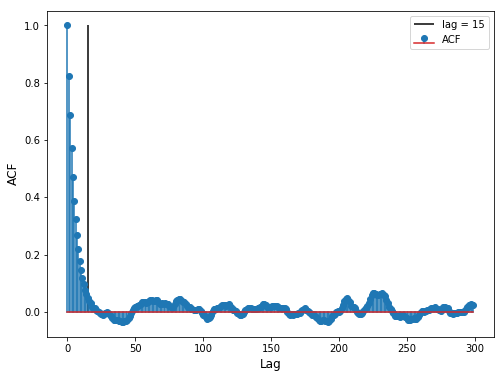

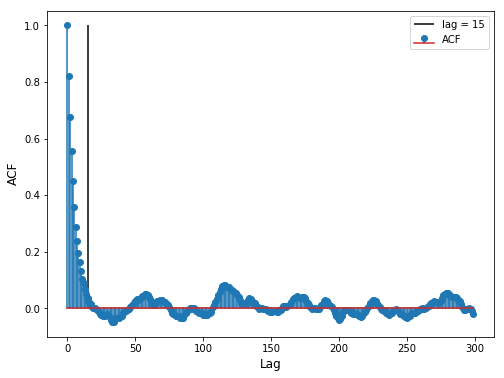

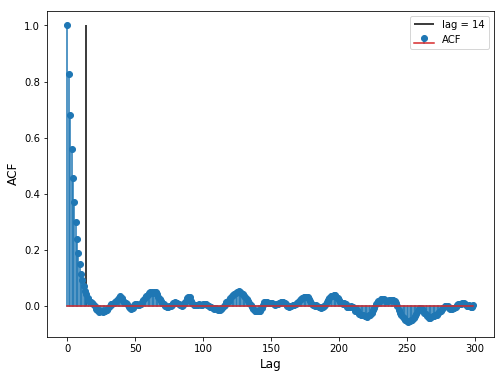

Next sequence:




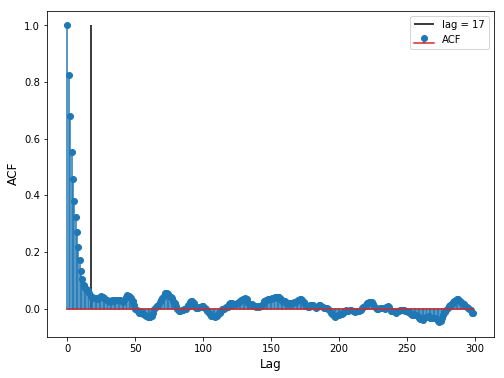

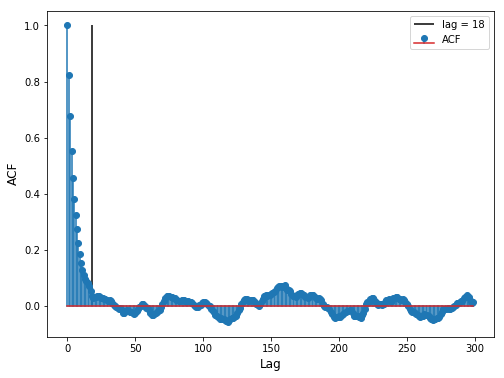

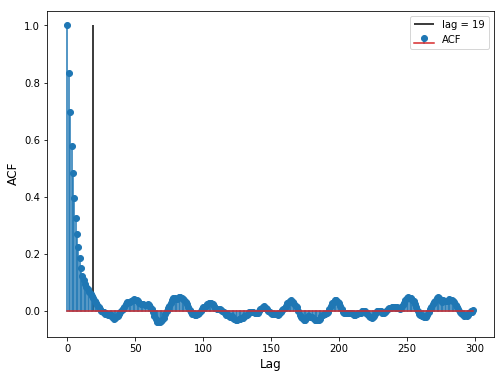

Next sequence:




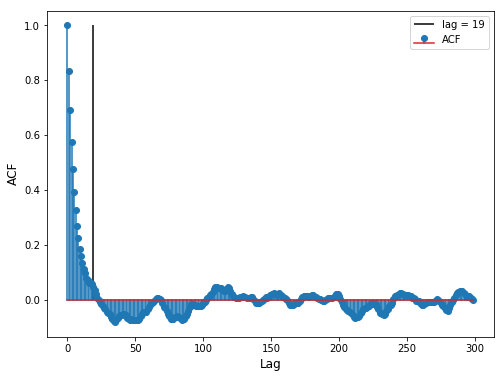

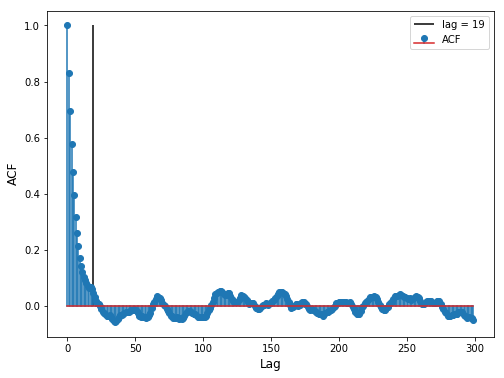

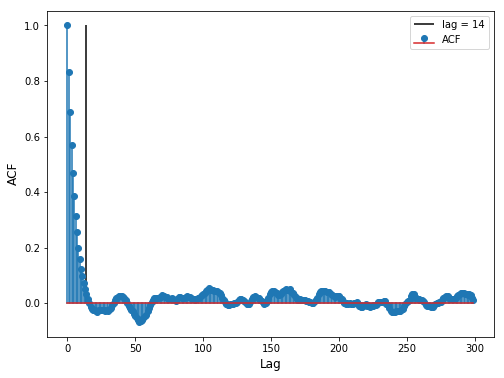

In [34]:
lag_u = []
lag_s = []
lag_shape = []
for i in range(len(u_raw)):
    lag_u.append(ACF(u_raw[i][burnin:], end=300))
    lag_s.append(ACF(s_raw[i][burnin:], end=300))
    lag_shape.append(ACF(shape_raw[i][burnin:], end=300))
    if (i < len(u_raw)-1):
        print ('Next sequence:')
    print ()
    print ()

## Final process:

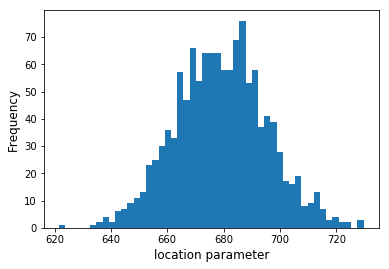

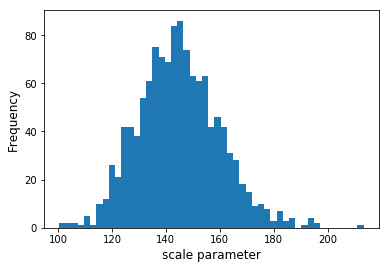

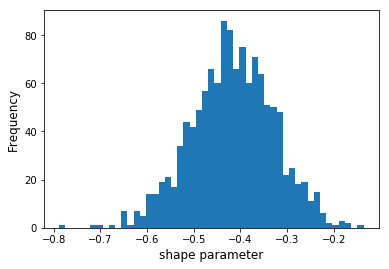

In [35]:
# merge the parameters

m = len(u_raw)

n_iter = len(u_raw[0])

lags = [max([lag_u[i], lag_s[i], lag_shape[i]]) for i in range(m)]

# this is the final list for location parameter
u_analysis = [] 

# this is the final list for scale parameter
s_analysis = []

# this is the final list for shape parameter
shape_analysis = []


# this is a list of tuples, each tupel is in this format (location, scale, shape)
params_analysis = []


# merge all three sequences 
for i in range(m):
    for j in range(burnin, n_iter, lags[i]):
        u_analysis.append(u_raw[i][j])
        s_analysis.append(s_raw[i][j])
        shape_analysis.append(shape_raw[i][j])
        params_analysis.append((u_raw[i][j], s_raw[i][j], shape_raw[i][j]))

# plot the histogram for each parameter
plt.hist(u_analysis, bins=np.linspace(min(u_analysis), max(u_analysis)))
plt.xlabel('location parameter', fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()
plt.hist(s_analysis, bins=np.linspace(min(s_analysis), max(s_analysis)))
plt.xlabel('scale parameter', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
plt.hist(shape_analysis, bins=np.linspace(min(shape_analysis), max(shape_analysis)))
plt.xlabel('shape parameter', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [36]:
# RL_100 is list of RL100 for each parameter set

RL_100 = []
for i in range(len(params_analysis)):
    RL_100.append(stats.genextreme.ppf(q=0.99, c=params_analysis[i][2], loc=params_analysis[i][0], scale=params_analysis[i][1]))

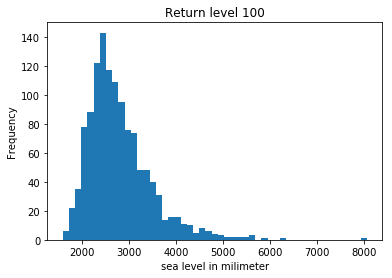

In [55]:

# Try RL 100 first for each parameter set
plt.hist(RL_100, bins=np.linspace(min(RL_100), max(RL_100)))
plt.title('Return level 100')
plt.xlabel('sea level in milimeter')
plt.ylabel('Frequency')
plt.show()

In [50]:

# RL is a list of lists, for example, the RL[0] is the list of the corresponding RL_1 for each parameter set
RL = []

# The RP = 1/(1-103/104) = 104，since there are only 103 years we can use from data_meas
RP = 1001

# This the list for RL of the parameter set which has highest ls score
RL_max = []

# Calculate RL for each RP and each parameter set
for i in range(RP):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/(i+1)), c=max_params[2], loc=max_params[0], scale=max_params[1]))
    for j in range(len(params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/(i+1)), c=params_analysis[j][2], loc=params_analysis[j][0], scale=params_analysis[j][1]))

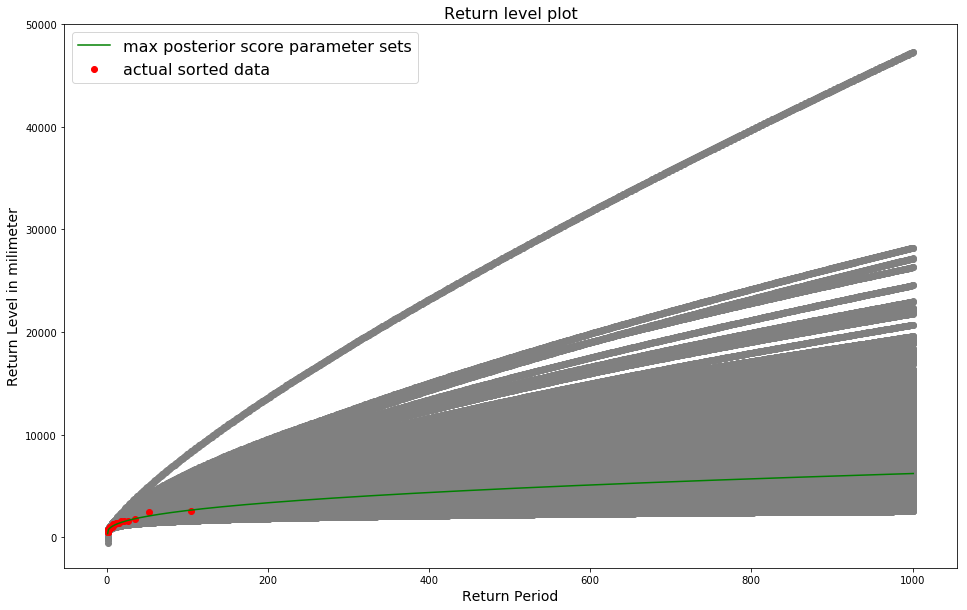

In [51]:
plt.figure(figsize=(16, 10))
for i in range(RP):
    x = [i+1]*len(RL[i]) # set the x coordinates for RP i
    plt.scatter(x, RL[i], color='grey')
    
ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    
    
plt.plot(np.arange(1, RP+1, 1), RL_max, color='g', label='max posterior score parameter sets')
plt.scatter([(len(data_meas)+1)/(len(data_meas)+1-k) for k in np.arange(1, len(data_meas)+1, 1)], np.sort(data_meas), label='actual sorted data', color='r')
plt.legend(loc='best', fontsize=16)
plt.xlabel('Return Period', fontsize=14)
plt.ylabel('Return Level in milimeter', fontsize=14)
plt.title('Return level plot', fontsize=16)
plt.show()

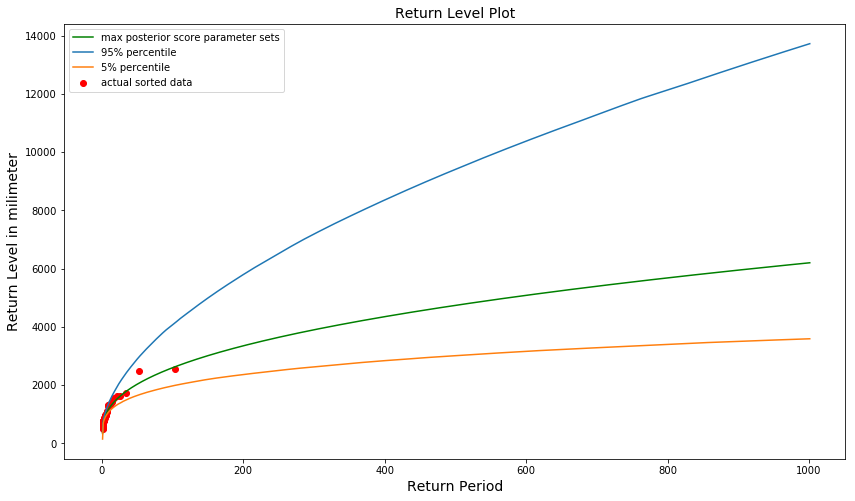

In [72]:
RL_95 = []
RL_5 = []
for i in range(len(RL)):
    RL_95.append(np.percentile(RL[i], 95))
    RL_5.append(np.percentile(RL[i], 5))
    
plt.figure(figsize=(14, 8))
plt.plot(np.arange(1, RP+1, 1), RL_max, color='g', label='max posterior score parameter sets')
plt.plot(np.arange(1, RP+1, 1), RL_95, label='95% percentile')
plt.plot(np.arange(1, RP+1, 1), RL_5,  label='5% percentile')
plt.scatter([(len(data_meas)+1)/(len(data_meas)+1-k) for k in np.arange(1, len(data_meas)+1, 1)], np.sort(data_meas), label='actual sorted data', color='r')
plt.legend(loc='best')
plt.xlabel('Return Period', fontsize=14)
plt.ylabel('Return Level in milimeter', fontsize=14)
plt.title('Return Level Plot', fontsize=14)
plt.show()

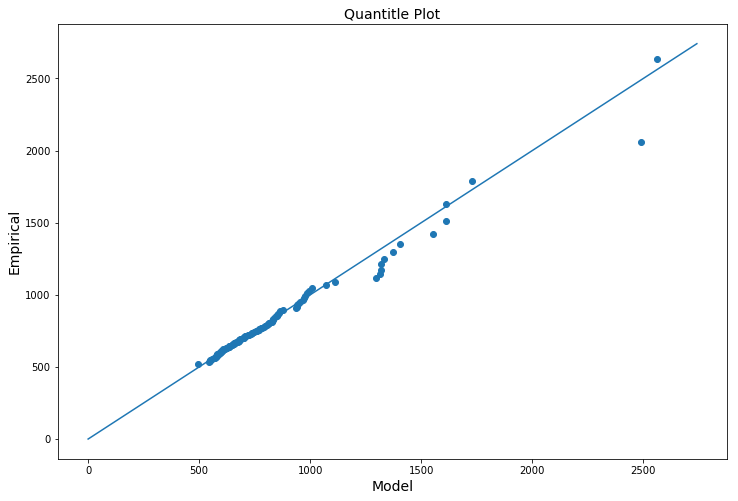

In [79]:
empirical = [stats.genextreme.ppf(q=(i+1)/(len(data_meas)+1), c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
plt.figure(figsize=(12, 8))
plt.scatter(np.sort(data_meas), empirical)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
axmax = max([xmax, ymax])
plt.plot(np.arange(0, axmax), np.arange(0, axmax))
plt.title('Quantitle Plot', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical', fontsize=14)
plt.show()

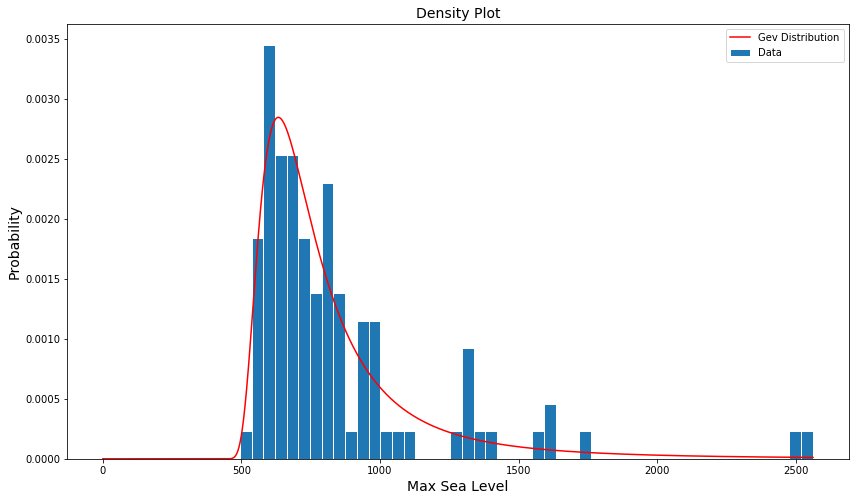

In [112]:
x_range = np.arange(0, max(data_meas)+1, 1)
y_range = [stats.genextreme.pdf(x=xi, c=max_params[2], loc=max_params[0], scale=max_params[1]) for xi in x_range]
plt.figure(figsize=(14,8))
plt.hist(data_meas, bins=np.linspace(min(data_meas), max(data_meas)), normed=True, edgecolor='white', label='Data')
plt.plot(x_range, y_range, label='Gev Distribution', color='r')
plt.legend()
plt.title('Density Plot', fontsize=14)
plt.xlabel('Max Sea Level', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.show()